
# MNIST Dataset Classification using Federated Learning

This notebook demonstrates how to classify the MNIST dataset using Federated Learning with the Flower (`flwr`) framework and TensorFlow. 
Federated Learning is a type of machine learning where multiple clients (devices) collaboratively train a model while keeping their data local, 
thus preserving data privacy. 

In this tutorial, you will learn how to:
- Set up a federated learning environment using Flower and TensorFlow.
- Train a model across multiple clients without sharing their data.
- Evaluate the performance of the federated model.

Let's get started by installing the necessary dependencies and importing the required libraries.
    

### Install dependencies & Import libraries

Next, we install the necessary packages
* Flower (`flwr`),
* TensorFlow (`tensorflow`),

!pip install -q flwr[simulation] tensorflow matplotlib;

In [ ]:
!pip install -q flwr[simulation] tensorflow matplotlib;


### Import Libraries

After installing the dependencies, we import the required libraries for this tutorial.
- `collections` and `typing`: For handling data structures.
- `matplotlib.pyplot` and `numpy`: For plotting and numerical operations.
- `tensorflow` and its modules: For building and training neural networks.
- `flwr`: For setting up and managing federated learning processes.
    

Now that we have all dependencies installed, we can import everything we need for this tutorial:

In [ ]:
from collections import OrderedDict
from typing import List, Tuple, Dict, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from tensorflow.keras.models import Model
import flwr as fl
from flwr.common import Metrics
from flwr.common.typing import NDArrays, Scalar

# Let's train on CPU
tf.config.set_visible_devices([], 'GPU')

print(
    f"Training on {'GPU' if tf.config.get_visible_devices('GPU') else 'CPU'} using TensorFlow {tf.__version__} and Flower {fl.__version__}"
)


Training on CPU using TensorFlow 2.15.0 and Flower 1.8.0


Let's define some useful constants that we will need along the tutorial.

In [ ]:
SEED = 42
NUM_CLIENTS = 10
BATCH_SIZE = 32
VALID_FRACTION = 0.2 # fraction of the dataset used for each local client
NUM_ROUNDS = 5

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def download_data() -> Tuple[np.ndarray, np.ndarray]:
    # Load the MNIST dataset
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Scale the input data to [0, 1]
    X_train = X_train / 255.0
    X_test = X_test / 255.0

    # Add a channel dimension to the input data (required by Conv2D layers)
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    return (X_train, y_train), (X_test, y_test)
# Keep the x_test for (optional) centralized evaluation.
(X_train, y_train), (X_test, y_test) = download_data()

### Quick EDA

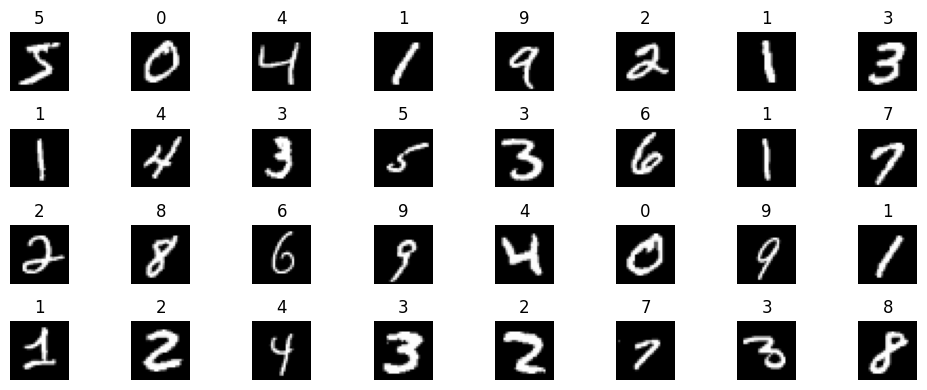

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = X_train[:32], y_train[:32]


# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(10, 4))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(labels[i])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()


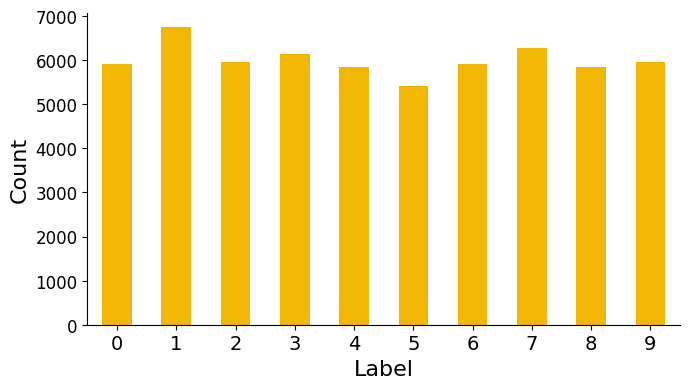

In [ ]:
labels = pd.Series(y_train)
counts = labels.value_counts().sort_index()
counts.plot.bar(figsize=(7, 4), color=["#F2B705"])
plt.ylabel("Count", fontsize=16)
plt.xlabel("Label", fontsize=16)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=12)
ax = plt.gca()
plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

We see that the data is quite evenly distributed. Let's sample the data random - iid sampling.

In [ ]:
def partition_data(X: np.ndarray, y: np.ndarray, n_partitions: int) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    """
    Split the dataset into iid partitions to simulate federated learning.

    Returns
    -------
    Tuple[List[np.ndarray], List[np.ndarray]]
        A list of X and y (one for each client)
    """
    X_split = np.split(X, NUM_CLIENTS)
    y_split = np.split(y, NUM_CLIENTS)
    return X_split, y_split

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def train_val_divide_local_datasets(local_X: List[np.ndarray], local_y: List[np.ndarray], valid_fraction: float) -> Tuple[Tuple[List[np.ndarray], List[np.ndarray]], Tuple[List[np.ndarray], List[np.ndarray]]]:
    """Split each local dataset into train and validation."""
    X_trains = []
    y_trains = []
    X_valids = []
    y_valids = []
    partition_size = local_X[0].shape[0]
    for client_x, client_y in zip(local_X, local_y):
        train_end_idx = int((1 - VALID_FRACTION) * partition_size)
        X_trains.append(client_x[:train_end_idx])
        y_trains.append(client_y[:train_end_idx])
        X_valids.append(client_x[train_end_idx:])
        y_valids.append(client_y[train_end_idx:])

    return (X_trains, y_trains), (X_valids, y_valids)

In [ ]:
def load_datasets(n_partitions: int, valid_fraction: float):
    """Handles the MNIST data creation for federated learning.

    It starts from downloading, thought partitioning, train test division and centralized dataset creation.

    Parameters
    ----------
    n_partitions: int
        The number of partitions the MNIST train set is divided into.
    valid_split: float
        The fraction of the validaiton data in each local dataset.

    Returns
    -------
    Tuple[List[DataLoader], List[DataLoader], DataLoader]
        Local train datasets, local validation datasets, and a centralized dataset
    """
    # DO NOT MODIFY THIS CODE
    (X_train, y_train), (centralized_X, centralized_y) = download_data()
    X_split, y_split = partition_data(X_train, y_train, n_partitions)
    (X_trains, y_trains), (X_valids, y_valids) = train_val_divide_local_datasets(X_split, y_split, valid_fraction)
    return (X_trains, y_trains), (X_valids, y_valids), (centralized_X, centralized_y)

In [ ]:
# DO NOT MODIFY THIS CODE
(X_trains, y_trains), (X_valids, y_valids), (centralized_X, centralized_y) = load_datasets(
    n_partitions=NUM_CLIENTS,
    valid_fraction=VALID_FRACTION)

## Test Solution using Centralized Training

we will test your solution by doing centralized training on one of the partitions of the data by simply running the code below.



In [ ]:
class CNN(Model):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = Conv2D(32, (3, 3), activation='relu')
        self.pool1 = MaxPooling2D((2, 2))
        self.conv2 = Conv2D(64, (3, 3), activation='relu')
        self.pool2 = MaxPooling2D((2, 2))
        self.flatten = Flatten()
        self.dense1 = Dense(128, activation='relu')
        self.dropout = Dropout(0.5)
        self.dense2 = Dense(10, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x)
        return self.dense2(x)

Run the centralized training.

In [ ]:
first_X_train, first_y_train = X_trains[0], y_trains[0]
first_X_valid, first_y_valid = X_valids[0], y_valids[0]
model = CNN()

model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(first_X_train, first_y_train, epochs=5, batch_size=BATCH_SIZE, validation_data=(first_X_valid, first_y_valid))

Epoch 1/5
150/150 [==============================] - 13s 75ms/step - loss: 0.8405 - accuracy: 0.7335 - val_loss: 0.2469 - val_accuracy: 0.9342
Epoch 2/5
150/150 [==============================] - 12s 77ms/step - loss: 0.2634 - accuracy: 0.9204 - val_loss: 0.1474 - val_accuracy: 0.9583
Epoch 3/5
150/150 [==============================] - 6s 38ms/step - loss: 0.1773 - accuracy: 0.9488 - val_loss: 0.1282 - val_accuracy: 0.9592
Epoch 4/5
150/150 [==============================] - 6s 42ms/step - loss: 0.1341 - accuracy: 0.9579 - val_loss: 0.1085 - val_accuracy: 0.9667
Epoch 5/5
150/150 [==============================] - 5s 33ms/step - loss: 0.1106 - accuracy: 0.9671 - val_loss: 0.1087 - val_accuracy: 0.9700


## Federated Learning

Now, we'll move to implementing federated learning system.

we need to implement `FlowerClinet`, create Flower Strategy e.g. `FedAvg` and start simulation.

### Updating model parameters

In federated learning, the server sends the global model parameters to the client, and the client updates the local model with the parameters received from the server. It then trains the model on the local data (which changes the model parameters locally) and sends the updated/changed model parameters back to the server (or, alternatively, it sends just the gradients back to the server, not the full model parameters).

Luckily, TensorFlow has `set_weigths` and `get_weights` methods. (Note that when working with PyTorch helper functions creation is needed to achieve that).

### Implement a Flower client

In Flower, we create clients by implementing subclasses of `flwr.client.Client` or `flwr.client.NumPyClient`. We use `NumPyClient` in this tutorial because it is easier to implement and requires us to write less boilerplate.

To implement the Flower client, we create a subclass of `flwr.client.NumPyClient` and implement the three methods `get_parameters`, `fit`, and `evaluate`.

In [ ]:
from flwr.common.typing import NDArrays
class FlowerClient(fl.client.NumPyClient):
    """
    Class representing a single client in FL system, required to use Flower.
    """
    def __init__(self, model: Model, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray):
        self.model = model
        self.model.build((32, 28, 28, 1))
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    def get_parameters(self, config):
        """Return the current local model parameters"""
        return self.model.get_weights()


    def fit(self, parameters: NDArrays, config: Dict[str, Scalar]) -> NDArrays:
        """Train the model on the local (train) data.

        Parameters
        ----------
        parameters: NDarrays
            Model parameters (weights) received from the server

        config: Dict[str, Scalar]
            Server based configuration (needed only if you require dynamically changing values).

        Returns
        -------
        NDArrays
            Updated model parameters

        """
        self.model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
        self.model.set_weights(parameters)
        self.model.fit(self.X_train, self.y_train, epochs=1, batch_size=BATCH_SIZE, verbose=0)
        return self.model.get_weights(), len(self.X_train), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar])-> Tuple[float, int, Dict[str, Scalar]]:
        """Evaluate model using the validation data.

        Parameters
        ----------
         parameters: NDarrays
            Model parameters (weights) received from the server

        config: Dict[str, Scalar]
            Server based configuration (needed only if you require dynamically changing values).

        Returns
        -------
        loss : float
            The evaluation loss of the model on the local dataset.
        num_examples : int
            The number of examples used for evaluation.
        metrics : Dict[str, Scalar]
            A dictionary mapping arbitrary string keys to values of
            type bool, bytes, float, int, or str. It can be used to
            communicate arbitrary values back to the server.
        """
        self.model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
        # self.model.build(input_shape=(32, 28, 28, 1))
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(self.X_test, self.y_test, batch_size=32, verbose=0)
        return loss, len(self.X_test), {"accuracy": accuracy}

Our class `FlowerClient` defines how local training/evaluation will be performed and allows Flower to call the local training/evaluation through `fit` and `evaluate`. Each instance of `FlowerClient` represents a *single client* in our federated learning system. Federated learning systems have multiple clients (otherwise, there's not much to federate), so each client will be represented by its own instance of `FlowerClient`. If we have, for example, three clients in our workload, then we'd have three instances of `FlowerClient`. Flower calls `FlowerClient.fit` on the respective instance when the server selects a particular client for training (and `FlowerClient.evaluate` for evaluation).

### Use the Virtual Client Engine

We will simulate a federated learning system with 10 clients on a single machine = 10 instances of `FlowerClient` in memory. Doing this on a single machine.

Flower creates `FlowerClient` instances only when they are actually necessary for training or evaluation by callling `client_fn` that returns a `FlowerClient` instance on demand. After using them for `fit` or `evaluate` they are discarded, so they should not keep any local state.

`client_fn` takes a single argument `cid` - a client ID. The `cid` can be used, for example, to load different local data partitions for different clients.

In [ ]:
# We can use the fact that we are using Jupyter Notebook environment and use the data without providing it as an argument.
def create_client_fn(cid: str) -> fl.client.Client:
    """Create a Flower client representing a single organization."""
    model = CNN()
    cid_int = int(cid)
    return FlowerClient(model, X_trains[cid_int], y_trains[cid_int], X_valids[cid_int], y_valids[cid_int]).to_client()


### Metrics Aggregation
Flower can automatically aggregate losses returned by individual clients, but it cannot do the same for metrics in the generic metrics dictionary (the one with the `accuracy` key). Metrics dictionaries can contain very different kinds of metrics and even key/value pairs that are not metrics at all, so the framework does not (and can not) know how to handle these automatically.

The `weighted_average` function has to be passed to `evaluate_metrics_aggregation_fn` in your strategy.

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

### Create a Strategy

Pick a strategy used for training. A good starting point is `FedAvg` but feel free to go throught the available strategies https://github.com/adap/flower/tree/main/src/py/flwr/server/strategy

In [ ]:
# Instantiate/Create a Flower strategy e.g. FedAvg
#TODO: Choose the strategy and specify the arguments
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,
)

### Run Flower Simulation

The function `flwr.simulation.start_simulation` accepts a number of arguments, amongst them the `client_fn` used to create `FlowerClient` instances, the number of clients to simulate (`num_clients`), the number of federated learning rounds (`num_rounds`), and the strategy. The strategy encapsulates the federated learning approach/algorithm, for example, *Federated Averaging* (FedAvg).

Flower has a number of built-in strategies, but we can also use our own strategy implementations to customize nearly all aspects of the federated learning approach. For this example, we use the built-in `FedAvg` implementation and customize it using a few basic parameters. The last step is the actual call to `start_simulation` which - you guessed it - starts the simulation:

In [ ]:
client_resources = {"num_cpus": 2}
if tf.config.get_visible_devices("GPU"):
    client_resources["num_gpus"] = 1


# Start simulation
history = fl.simulation.start_simulation(
    client_fn=create_client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
    client_resources=client_resources,
)

INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
INFO:flwr:Starting Flower simulation, config: num_rounds=5, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-04-22 11:46:42,363	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7708702311.0, 'object_store_memory': 3854351155.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7708702311.0, 'object_store_memory': 3854351155.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower

In [ ]:
history

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


History (loss, distributed):
('\tround 1: 0.3373421609401703\n'
 '\tround 2: 0.12380175739526748\n'
 '\tround 3: 0.09112109690904617\n'
 '\tround 4: 0.07603638917207718\n'
 '\tround 5: 0.06556918174028396\n')History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.9413333296775818),
              (2, 0.9633333206176757),
              (3, 0.9741666793823243),
              (4, 0.9760000228881835),
              (5, 0.9823333501815796)]}

## Centralized Evaluation

Modification of the strategy is needed for centralized evaluation.

In [ ]:
def evaluate(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
    ) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    """Centralized evaluation function"""
    model = CNN()
    model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
    model.build(input_shape=(BATCH_SIZE, 28, 28, 1))
    model.set_weights(parameters)
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
    return loss, {"accuracy": accuracy}

# TODO: Specify the Strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,
    evaluate_fn=evaluate
)

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=create_client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
    client_resources=client_resources,
)

INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
INFO:flwr:Starting Flower simulation, config: num_rounds=5, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-04-22 11:52:33,277	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7699705038.0, 'object_store_memory': 3849852518.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7699705038.0, 'object_store_memory': 3849852518.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower

In [ ]:
history

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


History (loss, distributed):
('\tround 1: 0.3687190651893616\n'
 '\tround 2: 0.12835117429494858\n'
 '\tround 3: 0.09163078218698502\n'
 '\tround 4: 0.08232205063104629\n'
 '\tround 5: 0.07002560123801231\n')History (loss, centralized):
('\tround 0: 2.297778367996216\n'
 '\tround 1: 0.34923794865608215\n'
 '\tround 2: 0.11600574851036072\n'
 '\tround 3: 0.08564291894435883\n'
 '\tround 4: 0.06847932189702988\n'
 '\tround 5: 0.060558002442121506\n')History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.9303333401679993),
              (2, 0.9614999890327454),
              (3, 0.9731666684150696),
              (4, 0.9775000214576721),
              (5, 0.9793333530426025)]}History (metrics, centralized):
{'accuracy': [(0, 0.13580000400543213),
              (1, 0.9368000030517578),
              (2, 0.9656000137329102),
              (3, 0.9728999733924866),
              (4, 0.9782999753952026),
              (5, 0.9807999730110168)]}